In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns

# Generate Datasets

In [61]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency

from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)

from functools import partial
from sklearn.model_selection import (cross_validate ,KFold ,ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.model_selection import train_test_split

In [62]:
Food = pd.read_csv("dataset/Food_Delivery_Times.csv")
print("Number of rows in the original dataset:", len(Food))

null_rows = Food.isnull().any(axis=1).sum()
print("Number of rows with missing values:", null_rows)

Food = Food.dropna()
print("Number of rows after removing missing values:", len(Food))

Food.head()

Number of rows in the original dataset: 1000
Number of rows with missing values: 117
Number of rows after removing missing values: 883


Order_ID  Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
0       522         7.93   Windy           Low   Afternoon      Scooter   
1       738        16.42   Clear        Medium     Evening         Bike   
2       741         9.52   Foggy           Low       Night      Scooter   
3       661         7.44   Rainy        Medium   Afternoon      Scooter   
4       412        19.03   Clear           Low     Morning         Bike   

   Preparation_Time_min  Courier_Experience_yrs  Delivery_Time_min  
0                    12                     1.0                 43  
1                    20                     2.0                 84  
2                    28                     1.0                 59  
3                     5                     1.0                 37  
4                    16                     5.0                 68

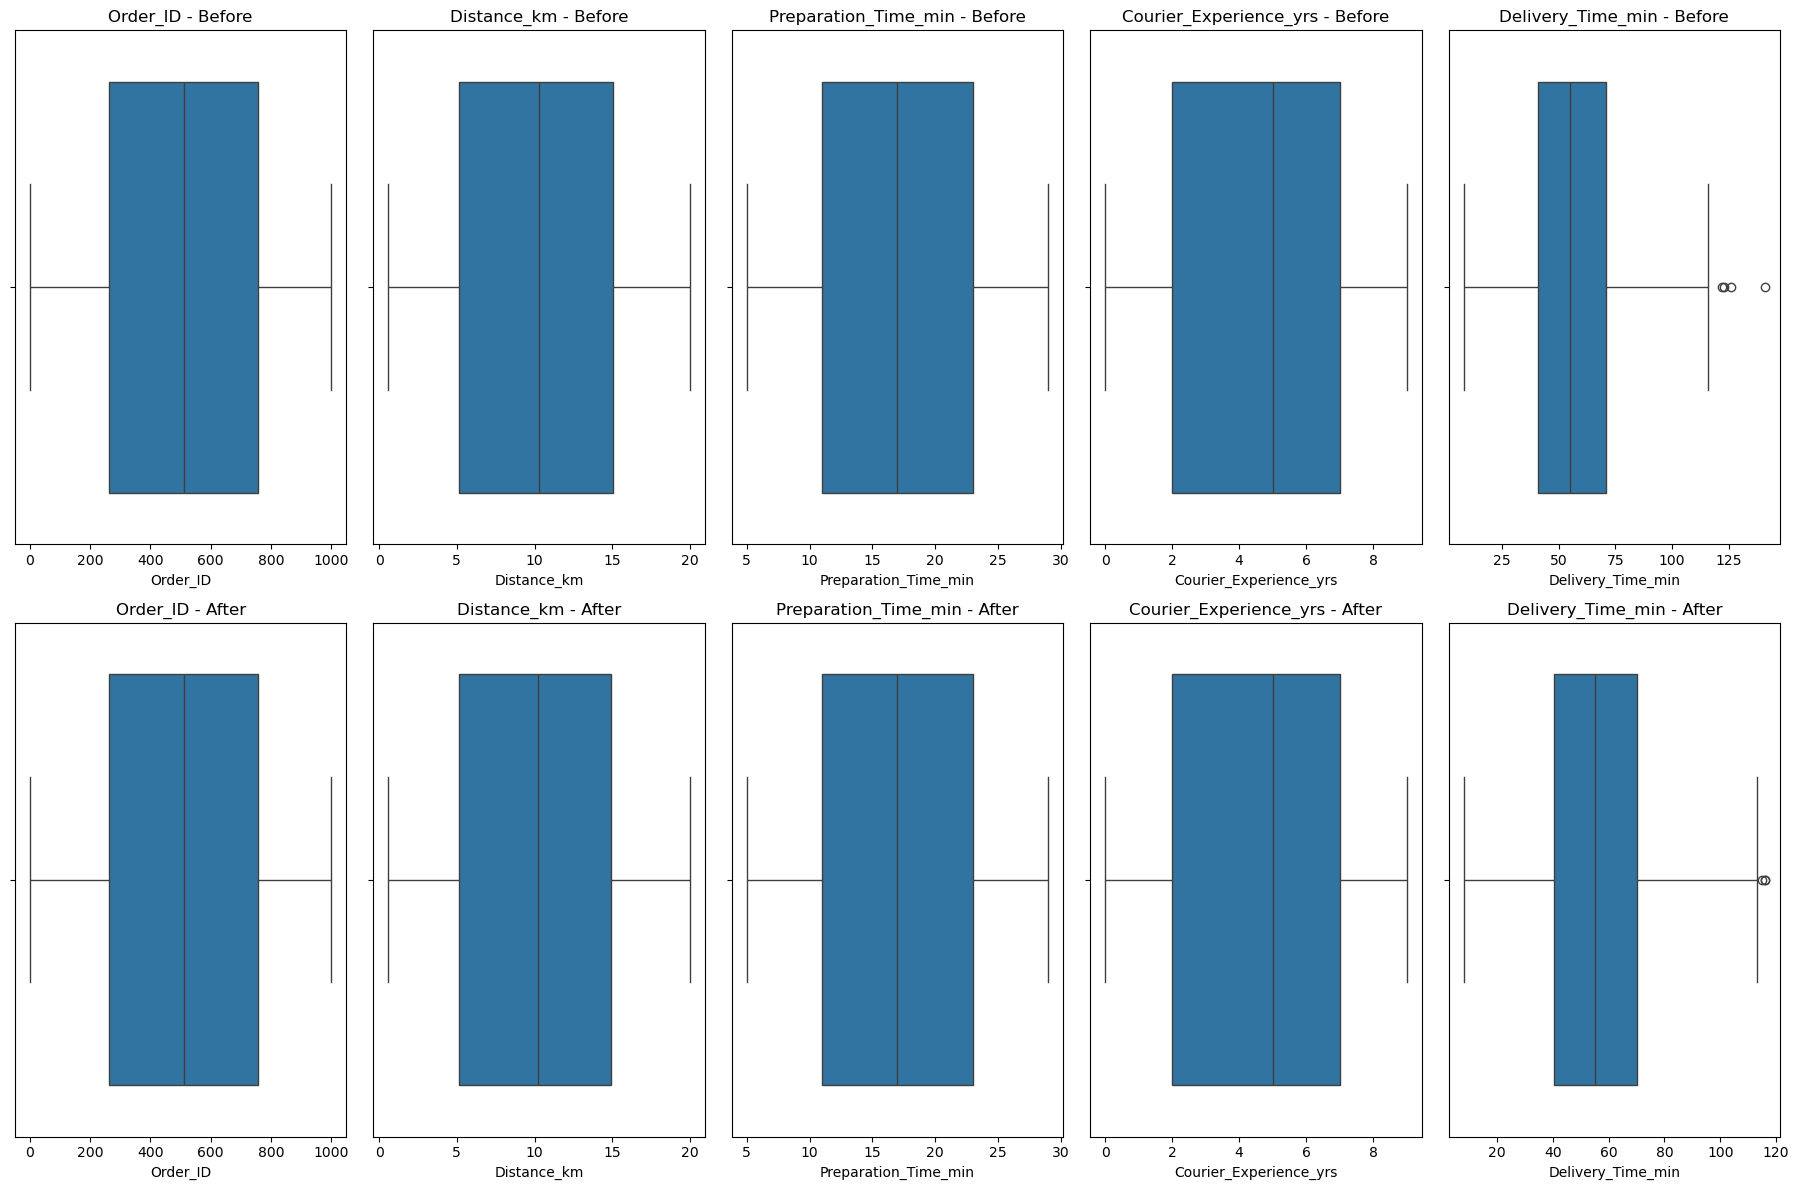

Number of rows after removing outliers 879


In [63]:
numeric_columns = Food.select_dtypes(include=['float64', 'int64']).columns

Food_original = Food.copy()

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in numeric_columns:
    Food = remove_outliers(Food, col)

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_columns, 1):

    plt.subplot(2, len(numeric_columns), i)
    sns.boxplot(x=Food_original[col])
    plt.title(f"{col} - Before")

    plt.subplot(2, len(numeric_columns), len(numeric_columns) + i)
    sns.boxplot(x=Food[col])
    plt.title(f"{col} - After")

plt.tight_layout()
plt.show()

print("Number of rows after removing outliers", len(Food))

In [110]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
Food[categorical] = Food[categorical].astype('category')

# Crea il modello con le specifiche
model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience_yrs'
])

# Applica la trasformazione
X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1
)

# -------------------- Classification Tree --------------------

In [111]:
# Train model
tree_model = DecisionTreeRegressor(random_state=2)
tree_model.fit(X_train, y_train)
# Indice di gini: quanto i nodi sono puri. Criterio simile a MSE ma per classificazione. Più è alto meglio è, indica che la variabile aiuta 

DecisionTreeRegressor(random_state=2)

In [112]:
# Summary and Visualization
print("Regression Tree:")
print(f"Tree depth: {tree_model.get_depth()}")
print(f"Number of leaves: {tree_model.get_n_leaves()}")
print(f"Feature importances: {tree_model.feature_importances_}")
print(f"Feature names: {tree_model.feature_names_in_}")

Regression Tree:
Tree depth: 17
Number of leaves: 398
Feature importances: [0.         0.7001131  0.01183811 0.00263364 0.02121531 0.00926998
 0.02381616 0.00397673 0.00608916 0.01150049 0.00701096 0.00797902
 0.00940639 0.15618443 0.02896653]
Feature names: ['intercept' 'Distance_km' 'Weather[Foggy]' 'Weather[Rainy]'
 'Weather[Snowy]' 'Weather[Windy]' 'Traffic_Level[Low]'
 'Traffic_Level[Medium]' 'Time_of_Day[Evening]' 'Time_of_Day[Morning]'
 'Time_of_Day[Night]' 'Vehicle_Type[Car]' 'Vehicle_Type[Scooter]'
 'Preparation_Time_min' 'Courier_Experience_yrs']


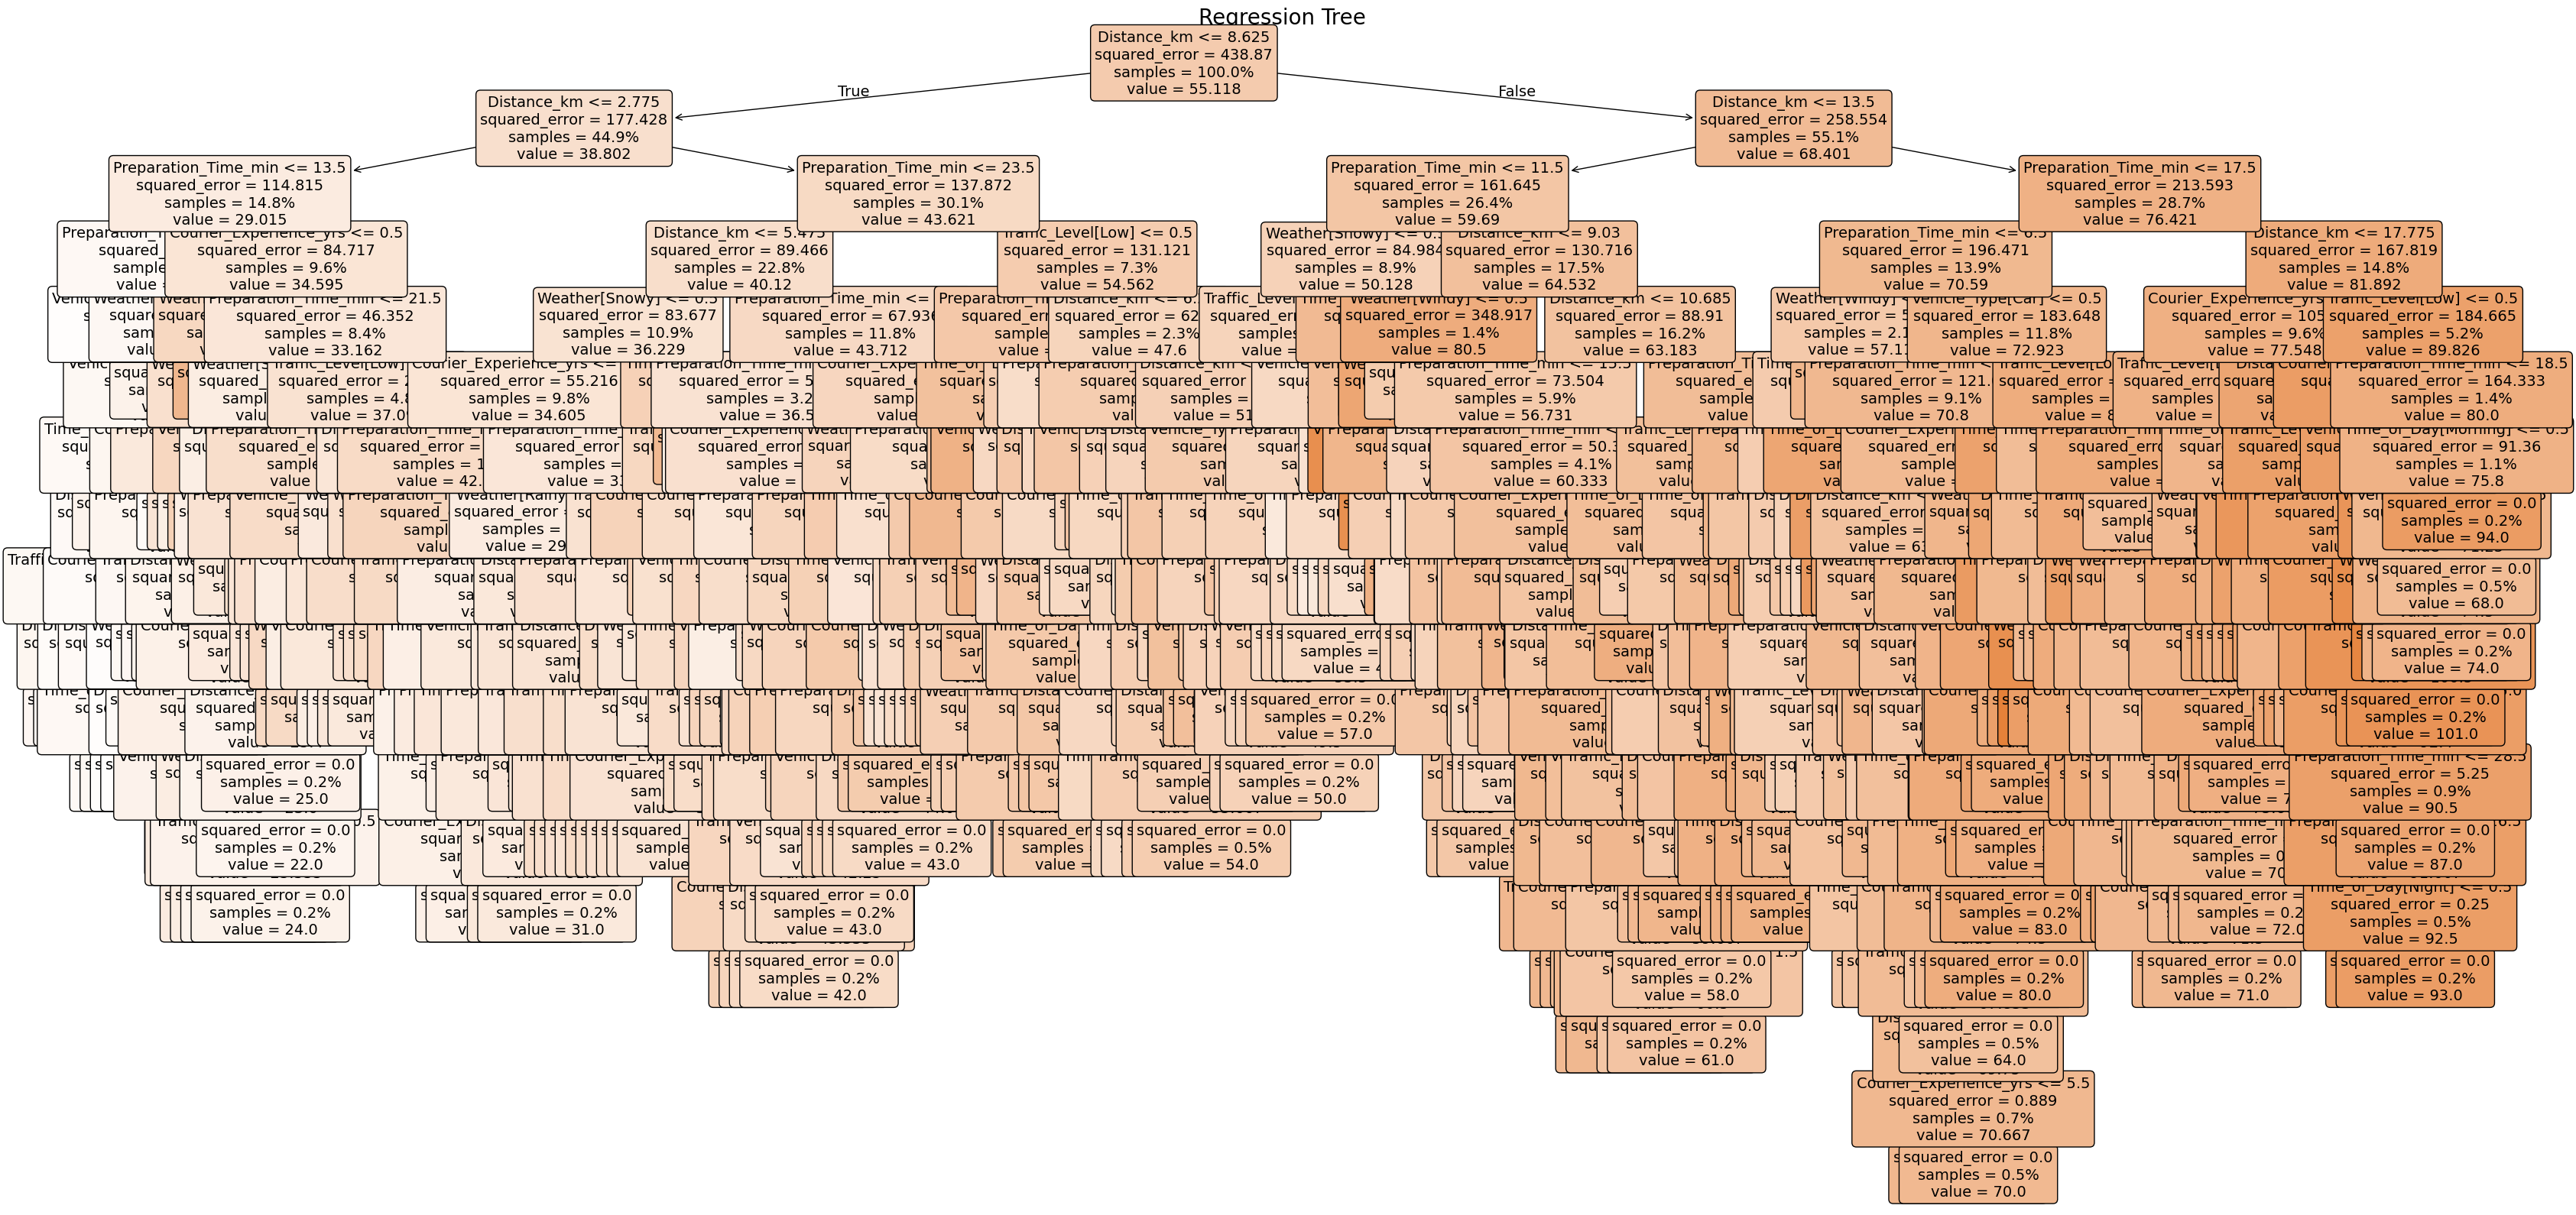

In [115]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plotting the tree with very high resolution for zooming
plt.figure(figsize=(40, 20))  # Aumenta la dimensione della figura per più spazio
plot_tree(tree_model, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          fontsize=14,  # Regola la dimensione del font per migliorare la leggibilità
          proportion=True)  # Distribuisce meglio i nodi
plt.title('Regression Tree', fontsize=20)  # Titolo con un font più grande

# Salva l'immagine con una risoluzione molto alta per renderla zoomabile
plt.savefig('tree_model_high_res.png', dpi=1200, bbox_inches='tight')  # DPI molto alto per qualità
plt.show()


In [100]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = tree_model.predict(X_test)

# Evaluate performance using regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Regression Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² (Coefficient of Determination): {r2:.4f}")

Regression Evaluation:
Mean Absolute Error (MAE): 10.9091
Mean Squared Error (MSE): 243.5227
R² (Coefficient of Determination): 0.4533


In [101]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Range di profondità massima per l'albero
max_depth_values = range(1, 21)  # Ho limitato a 20 per ragioni di performance, ma puoi adattare

cv_scores = []

# Cross-validation per ciascun valore di max_depth
for max_depth in max_depth_values:
    tree_model = DecisionTreeRegressor(random_state=2, max_depth=max_depth)
    scores = cross_val_score(tree_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')  # MSE per la regressione
    cv_scores.append(scores.mean())

# Trova la profondità ottimale
optimal_depth = max_depth_values[cv_scores.index(min(cv_scores))]
print(f"Optimal tree depth (based on cross-validation): {optimal_depth}")


Optimal tree depth (based on cross-validation): 1


In [102]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Range di profondità massima per l'albero
max_depth_values = range(1, 21)  # Puoi estendere questo range se necessario
cv_scores = []

# Cross-validation per ciascun valore di max_depth
for depth in max_depth_values:
    tree_cv = DecisionTreeRegressor(max_depth=depth, random_state=2)
    scores = cross_val_score(tree_cv, X_train, y_train, cv=10, scoring='neg_mean_squared_error')  # MSE per la regressione
    cv_scores.append(np.mean(scores))

# Trova la profondità ottimale
optimal_depth = max_depth_values[np.argmax(cv_scores)]
print(f"Optimal tree depth (based on cross-validation): {optimal_depth}")


Optimal tree depth (based on cross-validation): 3


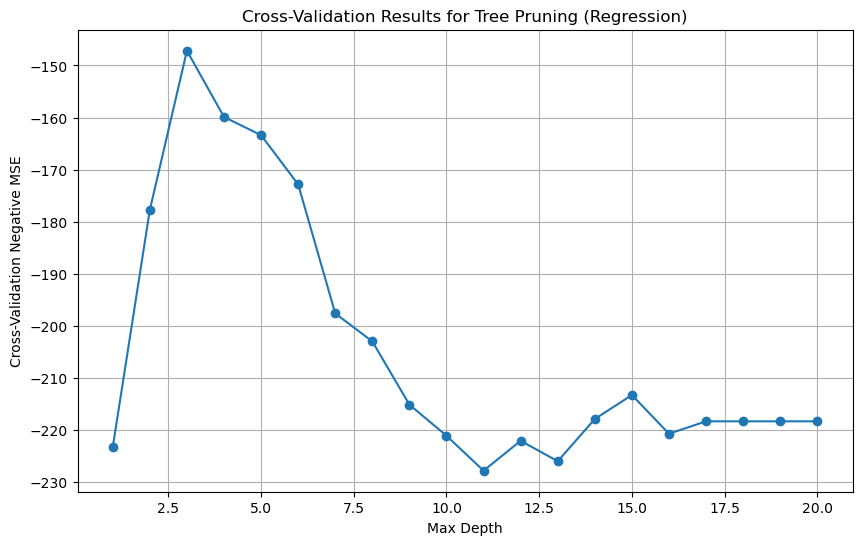

In [103]:
import matplotlib.pyplot as plt

# Plot cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, 'o-')
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validation Negative MSE')  # Cambiato in negativo MSE per la regressione
plt.title('Cross-Validation Results for Tree Pruning (Regression)')
plt.grid(True)
plt.show()


In [104]:
# Prune the tree (select best max_depth)
best_depth = max_depth_values[np.argmax(cv_scores)]
print(f"Best depth from cross-validation: {best_depth}")


Best depth from cross-validation: 3


In [105]:
# Train the pruned tree using the best depth for regression
pruned_tree = DecisionTreeRegressor(max_depth=best_depth, random_state=2)
pruned_tree.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=3, random_state=2)

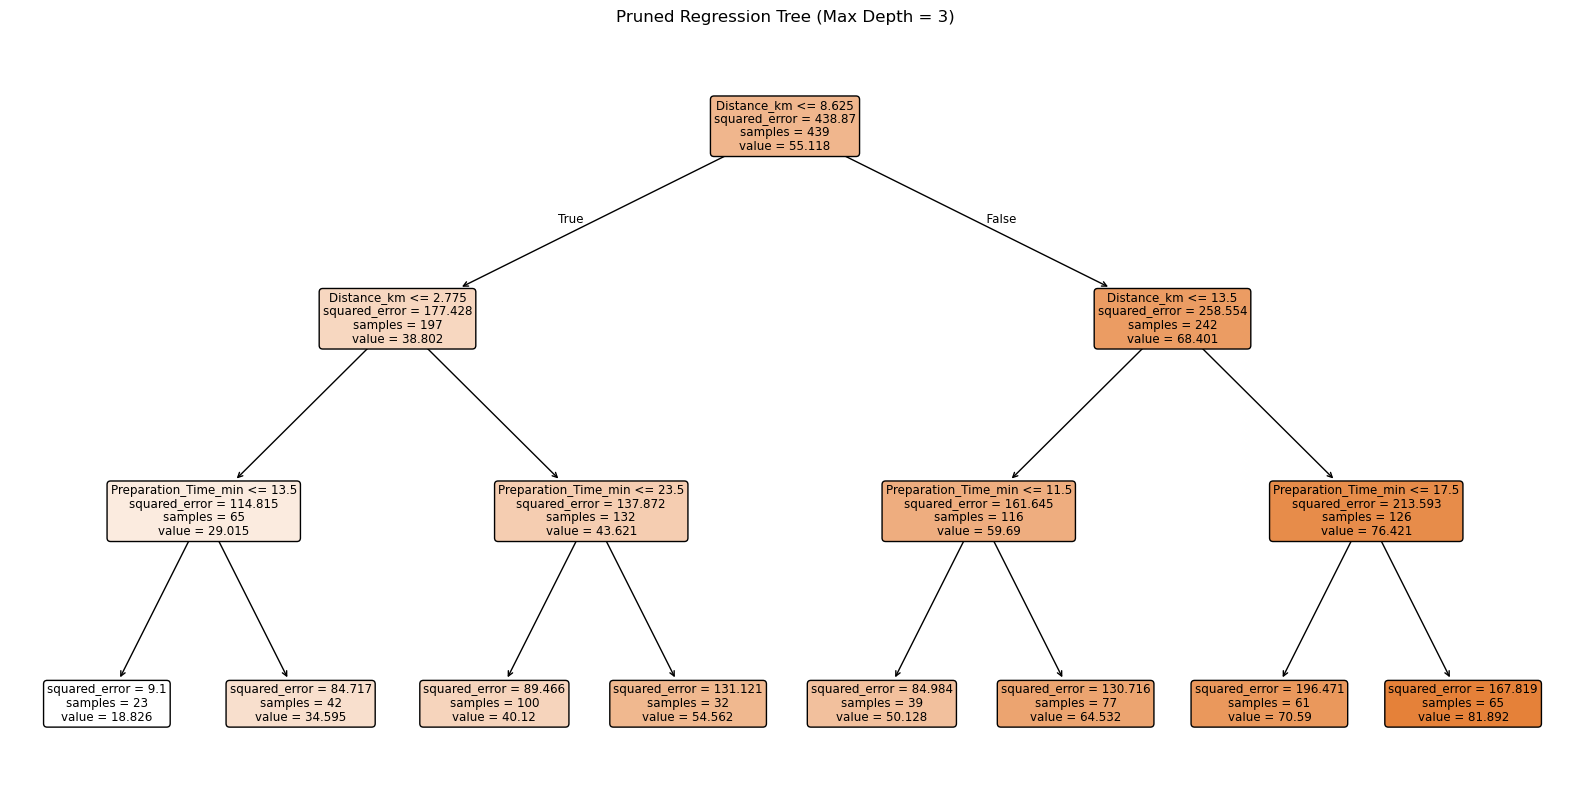

In [106]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot pruned tree
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree, feature_names=X.columns, filled=True, rounded=True)
plt.title(f'Pruned Regression Tree (Max Depth = {best_depth})')
plt.savefig('pruned_tree.png', dpi=300, bbox_inches='tight')
plt.show()


In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict and evaluate the pruned tree
y_pred_pruned = pruned_tree.predict(X_test)

# Evaluate performance using regression metrics
mae_pruned = mean_absolute_error(y_test, y_pred_pruned)
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
r2_pruned = r2_score(y_test, y_pred_pruned)

print("Pruned Tree Evaluation:")
print(f"Mean Squared Error (MSE): {mse_pruned:.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse_pruned):.4f}")
print(f"R² (Coefficient of Determination): {r2_pruned:.4f}")


Pruned Tree Evaluation:
Mean Squared Error (MSE): 174.6271
Root Mean Squared Error (RMSE): 13.2147
R² (Coefficient of Determination): 0.6079


Non è cosi brutto. Ma non è neanche bello rispetto al modello lineare su cui ci siamo fermati. (Confrontare risultati).

# -------------------- Bagging and Random Forest ----------------

In [116]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
Food[categorical] = Food[categorical].astype('category')

# Crea il modello con le specifiche
model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience_yrs'
])

# Applica la trasformazione
X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1
)

In [118]:
# Bagging (Random Forest with max features = total features)
bagg_model = RandomForestRegressor(
    n_estimators=500, 
    max_features=X.shape[1],  # Use all features (equivalent to bagging)
    random_state=1,
    bootstrap=True  # Use bootstrap samples
)
bagg_model.fit(X_train, y_train)

RandomForestRegressor(max_features=15, n_estimators=500, random_state=1)

c:\Users\Asus\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\Asus\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\Asus\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\Asus\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\Asus\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\A

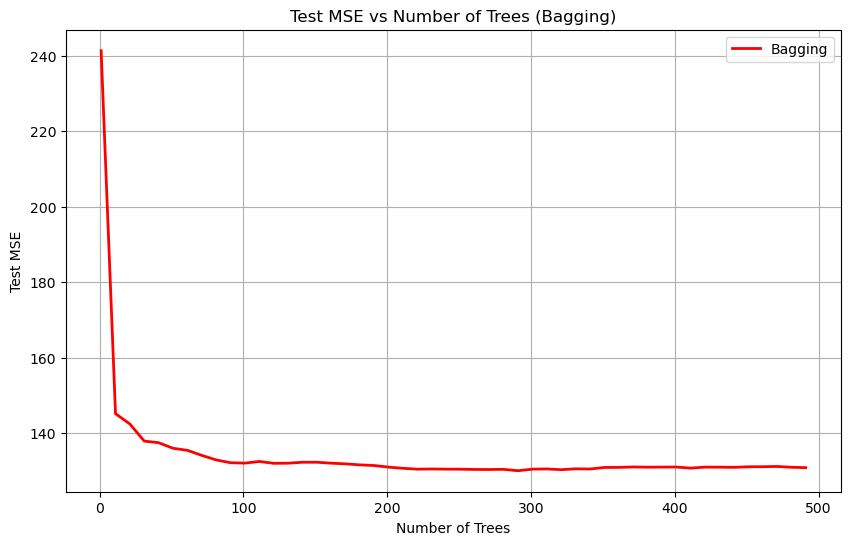

In [119]:
# Plot error vs number of trees
error_rate = []
for i in range(1, 501, 10):
    y_pred_bagg = np.mean([t.predict(X_test) for t in bagg_model.estimators_[:i]], axis=0)
    error_rate.append(mean_squared_error(y_test, y_pred_bagg))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 501, 10), error_rate, 'r-', lw=2, label='Bagging')
plt.xlabel('Number of Trees')
plt.ylabel('Test MSE')
plt.title('Test MSE vs Number of Trees (Bagging)')
plt.legend()
plt.grid(True)
plt.show()

In [121]:
# Predictions and evaluation
y_pred_bagg = bagg_model.predict(X_test)
mse_bagg = mean_squared_error(y_test, y_pred_bagg)
print(f"Bagging MSE: {mse_bagg:.4f}")
print(f"Bagging RMSE: {np.sqrt(mse_bagg):.4f}")

Bagging MSE: 130.8945
Bagging RMSE: 11.4409


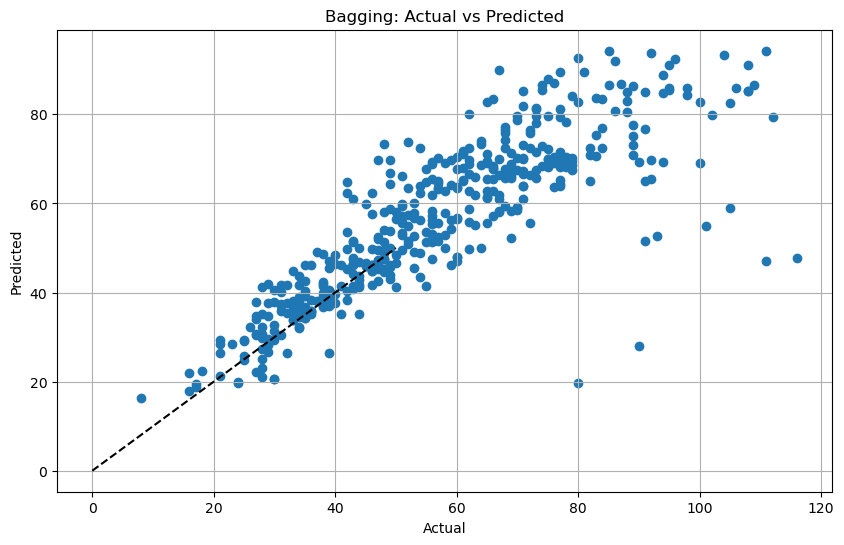

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_bagg)
plt.plot([0, 50], [0, 50], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Bagging: Actual vs Predicted')
plt.grid(True)
plt.show()
# Se sono sulla bisettrice il modello funziona bene, modello con bagging stimato corretto. Migliore del singolo albero ma comunque peggiore dei lineari

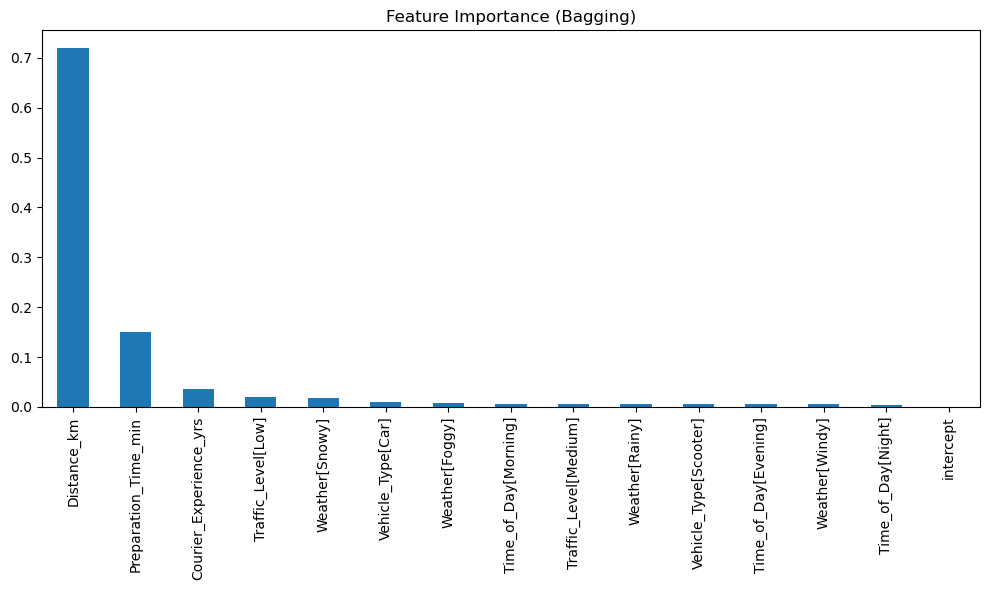

In [123]:
# Feature importance for bagging
importance_bagg = pd.Series(bagg_model.feature_importances_, index=X.columns)
importance_bagg.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
importance_bagg.plot(kind='bar')
plt.title('Feature Importance (Bagging)')
plt.tight_layout()
plt.show()

In [124]:
# Random Forest (uses sqrt of number of features by default)
forest_model = RandomForestRegressor(
    n_estimators=100, 
    max_features='sqrt',  # Default for RandomForest
    random_state=1
)
forest_model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', random_state=1)

In [125]:
# Error vs number of trees for Random Forest
error_rate_rf = []
for i in range(1, 101, 2):
    y_pred_rf = np.mean([t.predict(X_test) for t in forest_model.estimators_[:i]], axis=0)
    error_rate_rf.append(mean_squared_error(y_test, y_pred_rf))

c:\Users\Asus\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\Asus\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\Asus\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\Asus\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\Asus\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\A

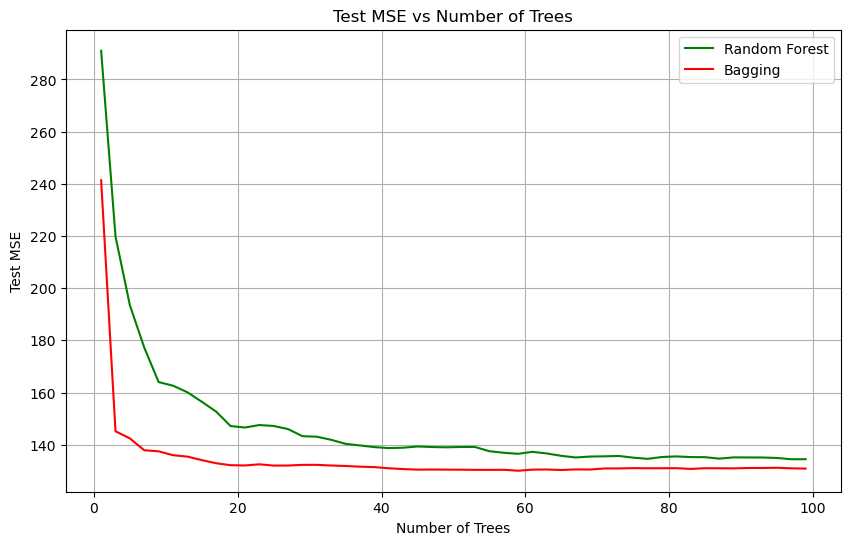

In [ ]:
# Plot both bagging and random forest error rates
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101, 2), error_rate_rf[:50], 'g-', label='Random Forest')
plt.plot(range(1, 101, 2), error_rate[:50], 'r-', label='Bagging')
plt.xlabel('Number of Trees')
plt.ylabel('Test MSE')
plt.title('Test MSE vs Number of Trees')
plt.legend()
plt.grid(True)
plt.show()
# In questo caso bagging funziona meglio, quindi questo è peggio

Random Forest MSE: 134.2502
Random Forest RMSE: 11.5866


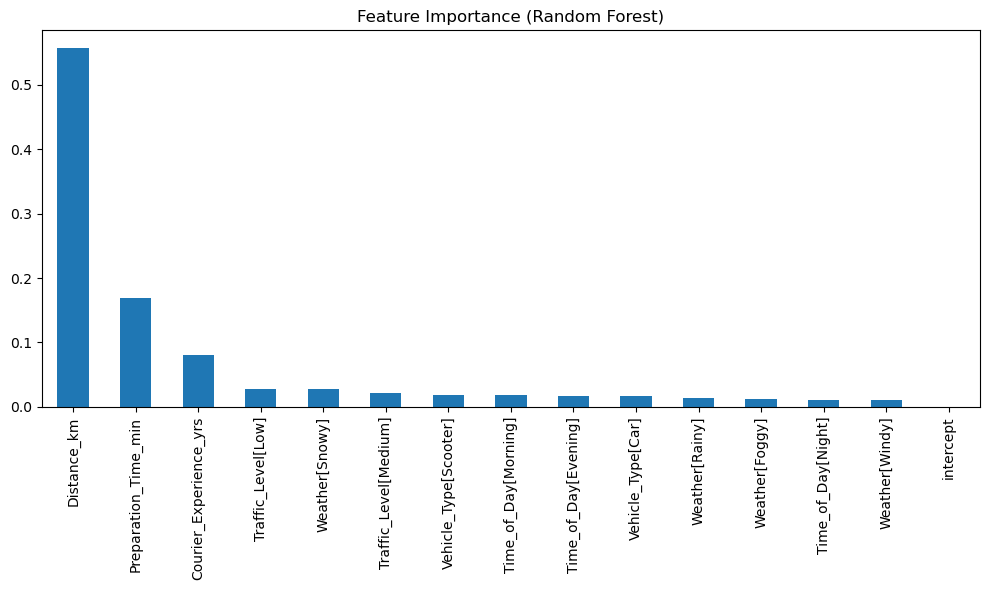

In [128]:
# Evaluation of Random Forest
y_pred_rf = forest_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf:.4f}")
print(f"Random Forest RMSE: {np.sqrt(mse_rf):.4f}")

# Feature importance for Random Forest
importance_rf = pd.Series(forest_model.feature_importances_, index=X.columns)
importance_rf.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
importance_rf.plot(kind='bar')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()
# Con random forest forziamo le altre variabili ad avere un ruolo più rilevante

# -------------------- Boosting --------------------

In [162]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
Food[categorical] = Food[categorical].astype('category')

# Crea il modello con le specifiche
model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience_yrs'
])

# Applica la trasformazione
X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1
)

In [175]:
# Gradient Boosting
boost_model = GradientBoostingRegressor(
    n_estimators=5000,
    max_depth=4,
    learning_rate=0.001,
    loss='squared_error',  # equivalent to 'gaussian' in R's gbm
    random_state=1
)
boost_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, max_depth=4, n_estimators=5000,
                          random_state=1)

In [176]:
# Predictions and evaluation
y_pred_boost = boost_model.predict(X_test)
mse_boost = mean_squared_error(y_test, y_pred_boost)
print(f"Boosting MSE: {mse_boost:.4f}")
print(f"Boosting RMSE: {np.sqrt(mse_boost):.4f}")

# Compare all methods
methods = ['Bagging', 'Random Forest', 'Boosting']
mse_values = [mse_bagg, mse_rf, mse_boost]

Boosting MSE: 120.1525
Boosting RMSE: 10.9614


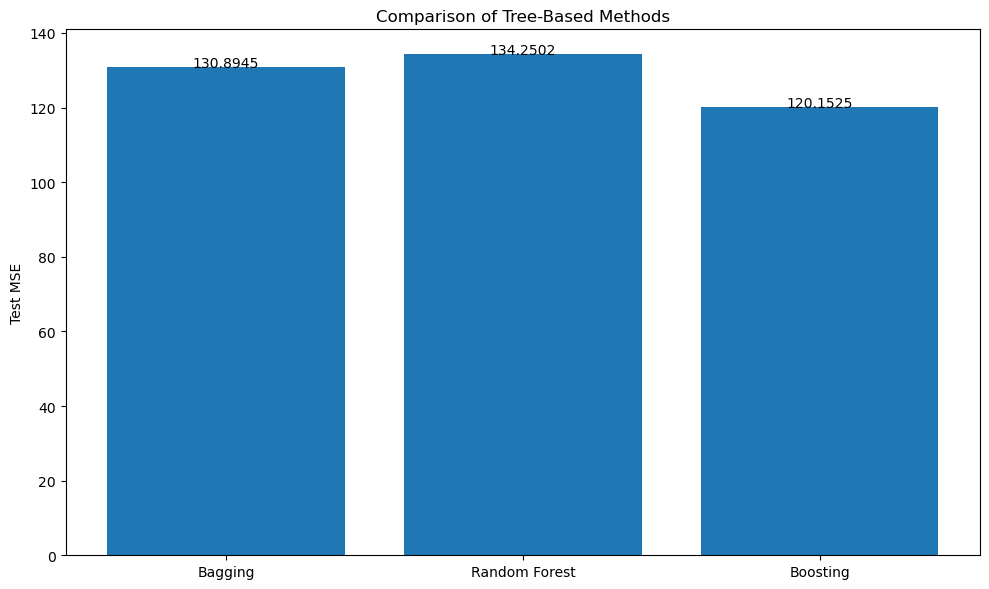

In [177]:
plt.figure(figsize=(10, 6))
plt.bar(methods, mse_values)
plt.ylabel('Test MSE')
plt.title('Comparison of Tree-Based Methods')
for i, v in enumerate(mse_values):
    plt.text(i, v + 0.1, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()